# LMB Python DNN Course Part 2

### Regression with proteomics profiles

This section is shifts from classification to regression tasks; using a neural network to predict continous outputs, rather than discrete categories. The data used here relates to proteomic profiles, which correspond to the relative abundances of proteins across several different experimental smamples. 

[kind of unsupervised learning]

### Section objectives

In this workbook we aim to:

* Show how neural networks can be used to predict continuous numeric data
* Use an autoencoder model to compress the data in a smaller latent vector
* Use the model to reonstruct clean data from corrupted input
* Illustrate use of the functional API in Karas3
* Illustrate the use of a customised loss function in Keras3
* Illustrate constructing neural networks with multiple outputs


### Module import

First we make some general imports for this notebook. NumPy is for using N-dimensional arrays and Matplotlib for plotting, as before.

In [33]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np # Load the NumPy module, assign it the name "np" for convienence
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (21,8) # Set plot size

Next we import the machine learning library Keras, and the `course_util` module that provides some helpful loading and plotting functions. The latter will keep the code clean and allow us to focus on the ML aspects. 

In [35]:
os.environ['KERAS_BACKEND'] = 'torch'
from keras import models, layers, regularizers, optimizers, utils
import keras
import course_util as util

### Loading profile data

A data file with over nine thousand proteomics profiles is provided in the same directory as this notebook. It can be loaded via the `util` module just imported. Loading data from this file gives both an array of protein profiles (a 2-D array with one protein per row), and an array of classifications, specified as integer indices. 

In [38]:
data_file = 'subcellular_proteomics.tsv'

profile_data, classifications = util.load_proteomics_data(data_file)
n, m = profile_data.shape

# Show array sizes
print('Profile array size:', profile_data.shape)
print('Class array size:', classifications.shape)

Profile array size: (9068, 84)
Class array size: (9068,)


Displaying the first profile shows it is simply an array of floating point values. Also, we can see that the protein classifications are an array of integers (each value represents a different subcellular location). Note that in these examples we will only be using the classifications to show the useful structure within the data, and we will not be predicting classification. 

In [37]:
# Show a bit of array data
print(profile_data[0])
print(classifications[:10])

[0.3060691 0.8172814 0.1011412 0.1080316 0.5624289 0.4546126 0.1346089
 0.0977268 1.        0.2378726 0.1796733 0.4292965 0.0616752 0.0483251
 0.2590052 0.2597435 0.0493709 0.0418346 0.3214187 0.2297825 0.3511028
 0.6833185 0.0916977 0.0569073 0.4796825 0.0316528 0.0814236 0.04731
 0.4645483 0.2265219 0.3950598 0.2778    0.2301824 0.0342367 0.0579839
 0.2988096 0.0267003 0.0518933 0.1580485 0.0233781 0.3591313 0.2087114
 0.4089022 0.1352241 0.1990526 0.0325448 0.0475561 0.0282691 0.017103
 0.0290381 0.0498324 0.2072349 0.1563567 0.1880095 0.1390077 0.1059399
 0.0322372 0.0449414 0.045126  0.0519548 0.0539543 0.0185487 0.2962564
 0.287059  0.3640223 0.1753668 0.233197  0.0374973 0.0835461 0.0291304
 0.0219324 0.0283921 0.0323295 0.        0.1595558 0.1055708 0.1589714
 0.0856071 0.0928666 0.0256852 0.013627  0.0133194 0.0037836 0.0179027]
[ 3  5 11 11  4 11  9 11  2  3]


### Plotting protein profile data

Plotting the original profile (red) and the sorted values (blue) for a specified row (index 0 here) shows that the data is already scaled to fit into the range [0, 1]. 

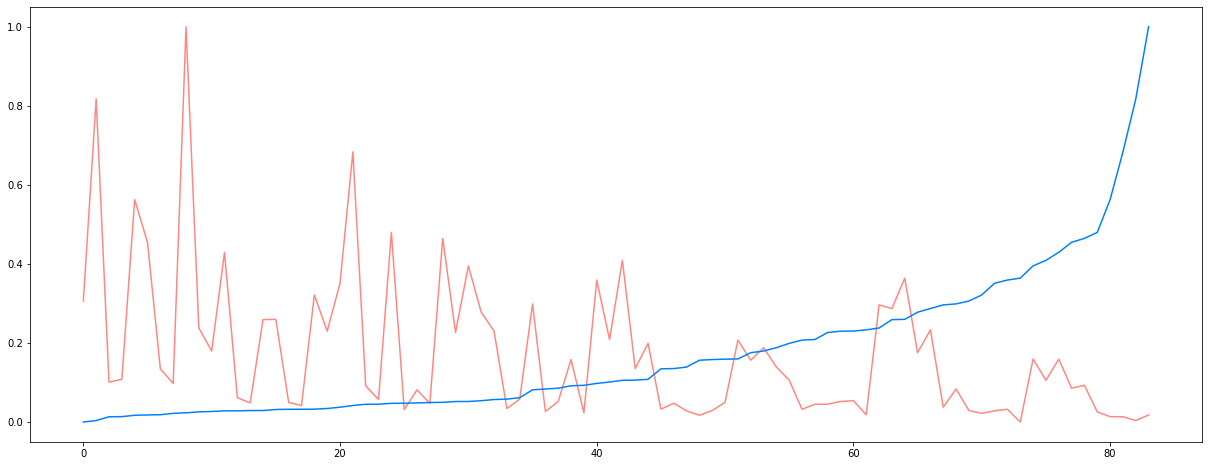

In [143]:
profile = profile_data[0]
plt.plot(profile, color='#FF1000', alpha=0.5)
plt.plot(sorted(profile), color='#0080FF')

By counting the non-zero values we can find the row with the most zeros, and plot its values to illustrate how data can be missing. In reality the zero values are a mixture of genuine nulls, values that fall below the detection threshold and random dropout from the stochastic nature of proteomic detection.   

6930


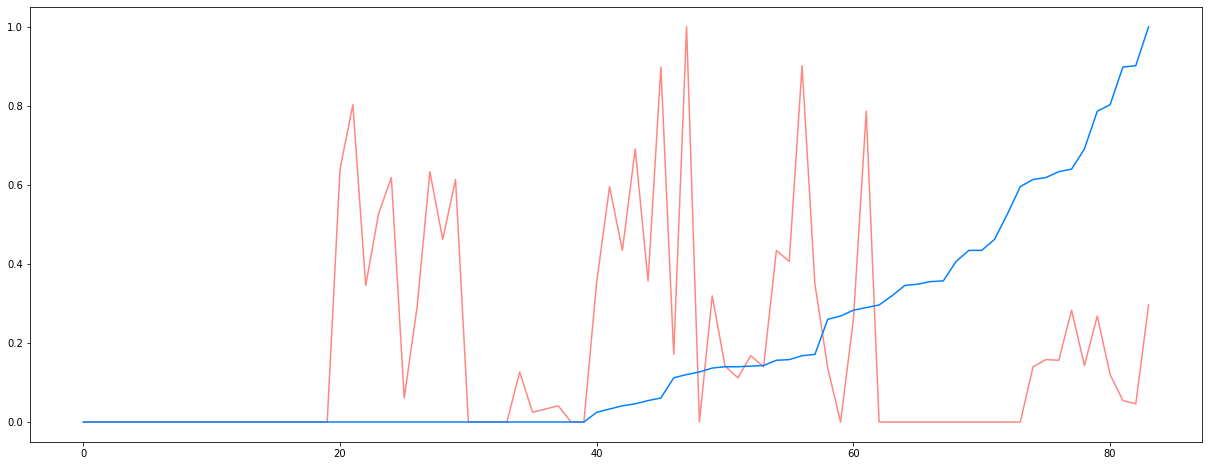

In [220]:
nz = np.count_nonzero(profile_data, axis=1)
idx = np.argsort(nz)
profile = profile_data[idx[0]]
plt.plot(profile, color='#FF1000', alpha=0.5)
plt.plot(sorted(profile), color='#0080FF')

With a utility function we can visualise the data points in a 2D map and colour according to classification (which relates to sub-cellular localisation) and accoding to the amount of data (non-zero values) present for each protein.
Here the 2D scatter plots are created using the UMAP method, which provides (X,Y) coordinates for each profile based upon their similarity (corralation in this case) to other profiles.

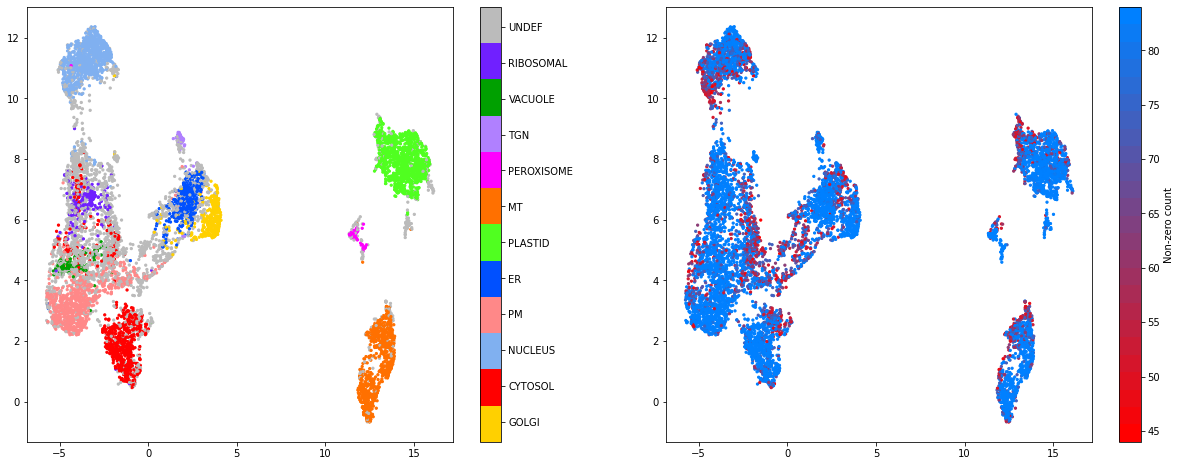

In [145]:
util.plot_proteomics_data(profile_data, classifications)

### Splitting test and train data

Next we use a handy function from the `sklearn` module to split the profile data randomly into a 20% test set, with the remaining 80% available for trainaing the a DNN. 

In [75]:
import sklearn
train_data, test_data = sklearn.model_selection.train_test_split(profile_data, test_size=0.2)
print(train_data.shape, test_data.shape)

(7254, 84) (1814, 84)


Now we come to specifying the architecture of the neural network, by defining the model; how its input connects to the output predictions via various intermediate layers. The objective  is to make what is termed an *autoencoder*. In essence, this means that the model will be trained to recreate its input. This could be done in a trivial manner by passing the input data through the network unaltered. However, here we choose to reduce the available vector width in the middle of the network (from 84 values to 16 in this case). Thus, the model has to learn to compress the input, to what we will term the *latent* vector, and then decompress this to the output. To add to this, we will also corrupt the input data, so that the model never sees the exact target values and has to learn how to de-noise and create clean data. Overall, the aim is to generate a compressed data representation that is structured and contains all the information necessary to represent the trainaing data. 

[Autoencoder diagram]

In the below examples we corrupt the input data in two ways, firstly by adding Gaussian noise (normally distributed) and secondly by masking out random elements of the input; setting them to zero. The latter will be addressed in a separate example as it requires careful consideration about the loss function used in training; we need to distinguish between true zeros and masked values.

For constructing the model using Keras, we will not use the Sequential construction shown earlier. Rather, we will be using the Keras functional API; this will give use the flexibility to have two model outputs. With the sequential mechanism we added layers to the end of a growing model, such that the output of the last layer is automatically joined to the input of the next. With the functional API we must explicitly link the different layers together and then create the Model, stating which layerts take input and which provide output.

To start we create an Input layer of the required width, `m` (the same with as out proteomic profiles; 84 in this case). Note how we assign this to the `x_in` variable; we will use this to specify what goes into the next layer.

In [178]:
x_in = layers.Input([m])

The next layer is a `GaussianNoise` layer with standard deviation `0.1` (and zero mean), so that random noise of this type will be numerically added to the input. Note that we first make the layer with `GaussianNoise(0.1)` and then after this add `(x_in)` to state that the constructed layer is to be run on this data. The output of this layer is just collected as `x`.

In [186]:
x = layers.GaussianNoise(0.1)(x_in)

Next we have three fully-connected `Dense` layers, with linear activations. For each the variable `x` is passed in at the end, as the layer's input and is collected at the layers output, i.e. the layer modifies `x`. These layers perform the data compression adn decompression, squeezeing the vector size in two stages to 16, and then re-expanding. 

In [187]:
x = layers.Dense(32, activation='linear')(x)
x = layers.Dense(16, activation='linear')(x)
x = layers.Dense(32, activation='linear')(x)

Finally we have a `Dense` layer with a `sigmoid` activation function, which is appropriate for outputting values in the range [0, 1], matching what we use in the traianing data. Here the layer with is `m`, and thus the same as the input data width. 

In [188]:
x_out = layers.Dense(m, activation='sigmoid')(x)

To turn this together into a model object, which we will label as `ae1`, we use `keras.Model` stating that `x_in` is the input variable and `x_out` is the output. It is notable that the specification here is via a list, and could accept multiple inputs and/or multiple outputs, as needed.

In [189]:
ae1 = keras.Model(inputs=[x_in], outputs=[x_out])

The model is compiled with the Adam optimiser, as used before. The loss function is `mae`, representing the mean abaolute error. As a trainaing metric we will also track the `mse`; mean squared error.

In [190]:
ae1.compile(optimizer=optimizers.Adam(1e-3), loss='mae', metrics=['mse',])
ae1.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_20               │ (None, 84)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 84)             │         2,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,564 (25.64 KB)

 Trainable params: 6,564 (25.64 KB)

 Non-trainable params: 0 (0.00 B)

Finally the model is trained for 20 iterations. Note how we pass-in `train_data` twice; once as the model input and once as the training target. Similarly `test_data` is used twice for validation/monitoring.

In [191]:
history1 = ae1.fit(train_data, train_data, epochs=20, batch_size=32,
                   validation_data=(test_data, test_data))

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2309 - mse: 0.0898 - val_loss: 0.1037 - val_mse: 0.0295
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0937 - mse: 0.0250 - val_loss: 0.0714 - val_mse: 0.0163
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0709 - mse: 0.0160 - val_loss: 0.0644 - val_mse: 0.0133
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0649 - mse: 0.0131 - val_loss: 0.0580 - val_mse: 0.0108
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0595 - mse: 0.0109 - val_loss: 0.0537 - val_mse: 0.0094
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0567 - mse: 0.0098 - val_loss: 0.0507 - val_mse: 0.0082
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0540 - mse: 0.0087 - val_loss: 0.0472 - val_mse: 0.0072
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0513 - mse: 0.0078 - val_loss: 0.0451 - val_mse: 0.0066
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

Plotting the training history shows that the model works well to minimise the error and recreate the output, despite the added noise, and show no sign of overtraining.

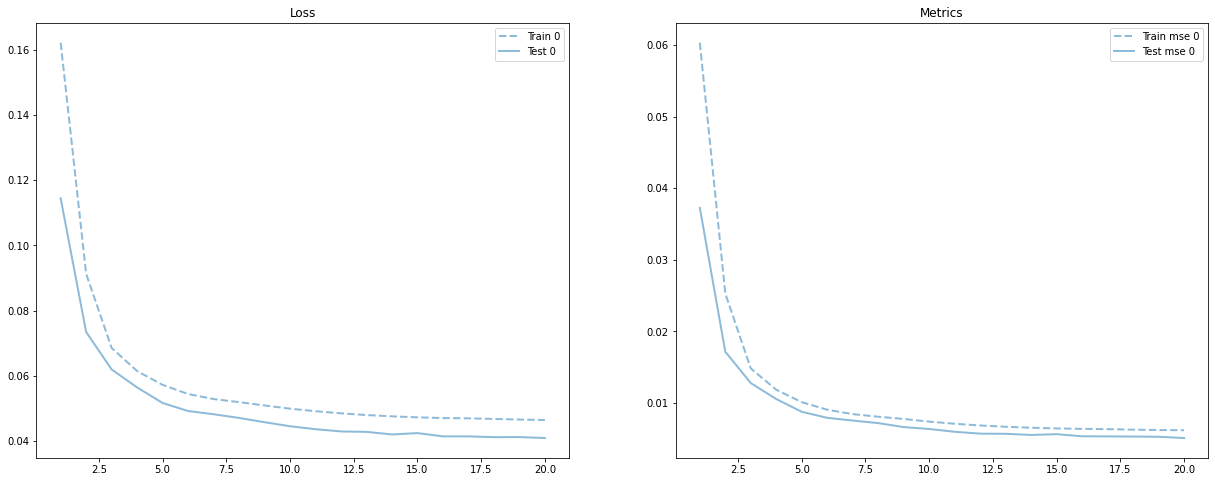

In [168]:
util.plot_training_history(history1)

### <font color=purple>Course Tasks</font>

<font color=purple>    
1. Train a similar model without the addition noise. What do you notice about the convergence of the test versus the train loss? Why does this happen?
</font>

<font color=purple>    
2. Train a similar model with a smaller latent vector size in the middle. What is the effect of this on the predictive performance? Can adding more `Dense` layers to the compression/decompresion stack change this? 
</font>


### Masked Input

The next example adapts the above autoencoder model to further corrupt the input. Specifically, random values from the input will be hidden, by setting them to zero. The task of the model will then be to not only remove the noise from the input, but also to reconstruct these zeroed values. 

To go along with this we will adjust the loss function used to train the model. The idea of using the mean abolute error will be kept in general, but a filter will be added to only use this for non-zero *target* data. Accordingly, the model *will* be trained to convert masked (synthetic) zero values to non-zero output, but *will not* be trained to convert natural zero inputs to zero outputs. 

Because predictions for original, natural zeros is not trained, the output for these will not be constrained to zero and the reconstructed value can freely adapt to any value suggested by the generality of the model , according to the rest of the data. Thus we can use this network to impute values for the zero values; in general these will be close to zero in any case, but we aim to fill useful missing values where the proteomic value was below the detection limit and/or the value dropped-out randomly. 

The Keras model `ae2` is constructed in the same manner as before, again using the functional API.

In [289]:
x_in = layers.Input([m])
x = layers.GaussianNoise(0.1)(x_in)
x = layers.Dense(32, activation='linear')(x)
x = layers.Dense(16, activation='linear')(x)
x = layers.Dense(32, activation='linear')(x)
x_out = layers.Dense(m, activation='sigmoid')(x)

ae2 = keras.Model(inputs=[x_in], outputs=[x_out])
ae2.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_31               │ (None, 84)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 84)             │         2,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,564 (25.64 KB)

 Trainable params: 6,564 (25.64 KB)

 Non-trainable params: 0 (0.00 B)

When compling the model we use the same optimiser, and follow the same metrics, but swap the standard mean absolute error loss function for a bespoke loss function. To construct a new loss function we simply write a Python function that takes two inputs; `y_target` is the ideal output and `y_pred` is the prediction from the model. The function returns a single value for the overall loss; the error between target and predicted values.

Within the function we use mathematical operations from Keras' `ops` module; `obs.abs()` calculates an absolute difference vector between the target and prediction, `ops.cast()` converts the boolean vector `y_true != 0` (that tests whether the target data is non-zero) into floating-point weights. These weights will be `0.0` for zeros in the target and `1.0` otherwise. The weights then multiply the absolute differences, such that only the non-zero values effect the loss. At the end the mean of the weighted differenes is passed back as the loss.

In [290]:
from keras import ops
def nonzero_mae(y_target, y_pred):
    abs_diff = ops.abs(y_target - y_pred)
    weights = ops.cast(y_target != 0, dtype='float32')
    return ops.mean(abs_diff * weights)  

The name of the Python function is then specified at the `loss` option when the model is compiled.

In [291]:
ae2.compile(optimizer=optimizers.Adam(1e-3), loss=nonzero_mae, metrics=['mse',])

Before the new model is trained, we take a copy of the training data and randonly replace replace a proportion (approximately 15% in this case) with zeros. These zeros are only used to make a new masked input, and are not applied to the target data (still the original `train_data` variable).  The same masking approach is applied to the test data so that we can see how well the reconstruction works on unseen data.

In [292]:
# Copy original training input
masked_train_data = np.array(train_data)

# The the probability of zeroing-out a value; approx. the masked proportion
mask_prob = 0.15

# Some uniformly distributed numbers within [0.0, 1.0]
ran = np.random.uniform(size=masked_train_data.shape)

# Set values below the mask threshold to zero
masked_data[ran < mask_prob] = 0.0

# Apply same approach to test data
masked_test_data = np.array(test_data)
masked_test_data[np.random.uniform(size=test_data.shape)< mask_prob] = 0.0

Using masked values takes a bit longer to train, so fitting is run for 30 cycles.

In [293]:
history2 = ae2.fit(masked_train_data, train_data, epochs=30, batch_size=32,
                   validation_data=(masked_test_data, test_data))

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2029 - mse: 0.0848 - val_loss: 0.0974 - val_mse: 0.0296
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0858 - mse: 0.0242 - val_loss: 0.0713 - val_mse: 0.0193
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0641 - mse: 0.0150 - val_loss: 0.0631 - val_mse: 0.0152
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0577 - mse: 0.0119 - val_loss: 0.0610 - val_mse: 0.0142
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0538 - mse: 0.0102 - val_loss: 0.0601 - val_mse: 0.0136
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0515 - mse: 0.0094 - val_loss: 0.0601 - val_mse: 0.0135
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0499 - mse: 0.0087 - val_loss: 0.0568 - val_mse: 0.0120
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0481 - mse: 0.0079 - val_loss: 0.0551 - val_mse: 0.0114
Epoch 9/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

Plotting the training metrics we see that it has worked well, though the MAE loss is not quite as good because we are now also training to reconstruct masked values. Note that the mean square error metric is not ideal here as it is still calculated for the zero targets. In a similar manner to the custom loss function, a special metric function could be written to account for this.

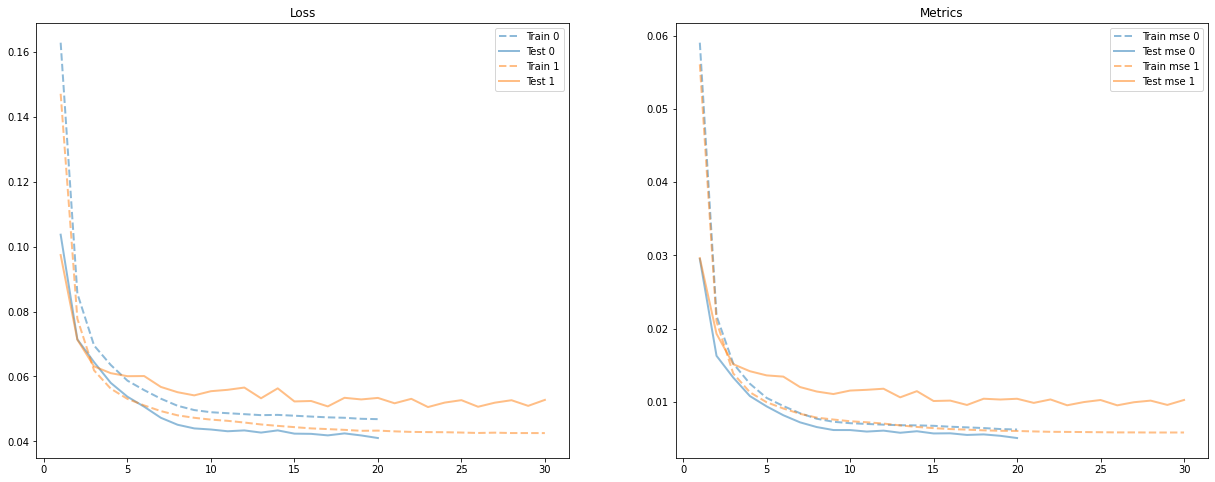

In [295]:
util.plot_training_history(history1, history2)     

To obtain full reconstructed profiles from the trained models we simply run the inference on the original input data via `predict()`. 

In [296]:
recon_data1 = ae1.predict(profile_data)
recon_data2 = ae2.predict(profile_data)
print(recon_data.shape)

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(1814, 84)


Plotting the inference values for a selected protein row (`idx`) shows how profile values have beed reconstructed.

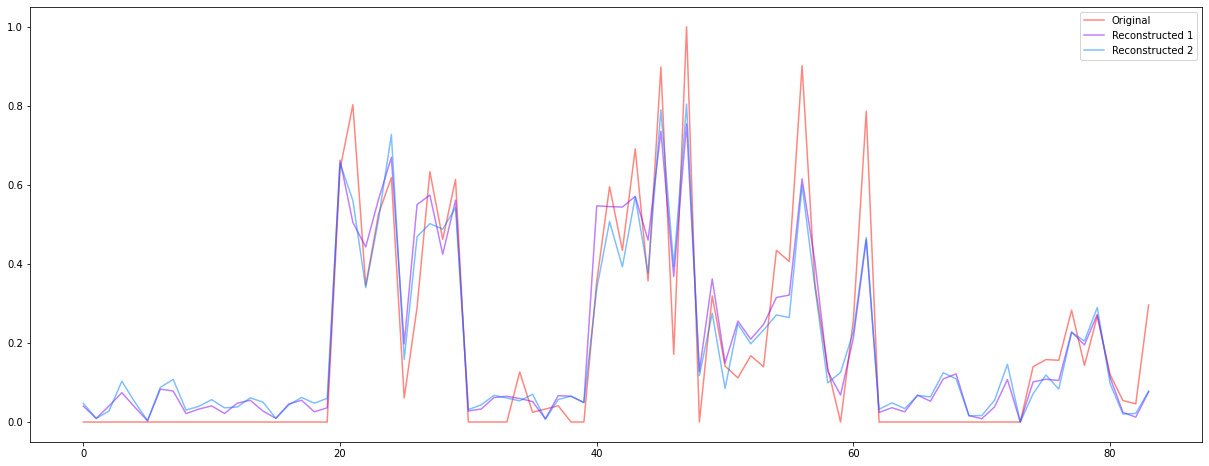

In [297]:
idx = 6930
plt.plot(profile_data[idx], color='#FF1000', alpha=0.5, label='Original')
plt.plot(recon_data1[idx], color='#8000FF', alpha=0.5, label='Reconstructed 1')
plt.plot(recon_data2[idx], color='#0080FF', alpha=0.5, label='Reconstructed 2')
plt.legend()

Similary we can plot scatters of the reconstructed output values to show how well they match the originals.

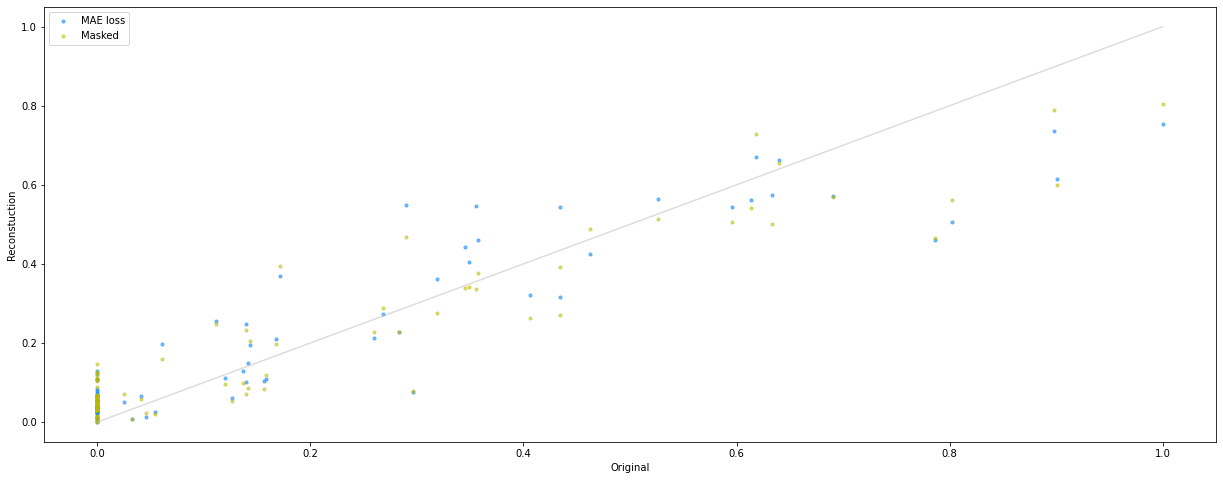

In [300]:
plt.plot([0.0, 1.0], [0.0, 1.0], color='#bbbbbb', alpha=0.5)
plt.scatter(profile_data[idx], recon_data1[idx], color='#0080FF', alpha=0.5, s=10, label='MAE loss')
plt.scatter(profile_data[idx], recon_data2[idx], color='#BBBB00', alpha=0.5, s=10, label='Masked')
plt.xlabel('Original')
plt.ylabel('Reconstuction')
plt.legend()

Next, the autoencoder model is adapted so that it outputs the latent vector (width 16) fro the middle of the model layers, as well as the final output. This is straightforward using the functional API; we simply assign a variable to the central layer output we wish to keep (`x_latent`) and add this as a model output at compile time

In [301]:
# First few layers same as before
x_in = layers.Input([m])
x = layers.GaussianNoise(0.1)(x_in)
x = layers.Dense(32, activation='linear')(x)

# Specially labelled middle layer, for keeping
x_latent = layers.Dense(16, name='latent', activation='linear')(x)

# Last layers as before, starting from x_latent
x = layers.Dense(32, activation='linear')(x_latent)
x_out = layers.Dense(m, name='out', activation='sigmoid')(x)

The model is define with the same input as before, but now with two outputs; the profile prediction and the latent vector. With two Keras outputs we must specify two losses and two metrics, but keep the second values as `None` as we dont want to use this output for training or comparision; there is nothing to compare with. In defferent circustances we might want two different loss functions, e.g. to reconstruct the data and to classify it.

In [286]:
ae3 = keras.Model(inputs=[x_in], outputs=[x_out, x_latent])
ae3.compile(optimizer=optimizers.Adam(1e-3),
            loss=[nonzero_mae,None], metrics=['mse',None])

ae3.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_30               │ (None, 84)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 84)             │         2,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,564 (25.64 KB)

 Trainable params: 6,564 (25.64 KB)

 Non-trainable params: 0 (0.00 B)

In [287]:
history3 = ae3.fit(masked_train_data, train_data, epochs=30, batch_size=32,
                   validation_data=(masked_test_data, test_data))

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1989 - out_mse: 0.0833 - val_loss: 0.0998 - val_out_mse: 0.0317
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0873 - out_mse: 0.0264 - val_loss: 0.0738 - val_out_mse: 0.0211
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0674 - out_mse: 0.0171 - val_loss: 0.0670 - val_out_mse: 0.0171
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0612 - out_mse: 0.0135 - val_loss: 0.0651 - val_out_mse: 0.0159
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0566 - out_mse: 0.0114 - val_loss: 0.0612 - val_out_mse: 0.0141
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0536 - out_mse: 0.0101 - val_loss: 0.0600 - val_out_mse: 0.0135
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0508 - out_mse: 0.0089 - val_loss: 0.0565 - val_out_mse: 0.0123
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0488 - out_mse: 0.0082 - val_loss: 0.0545 - val_out_mse:

The trainaing proceeds in an almost identical manner to before, as it ought.

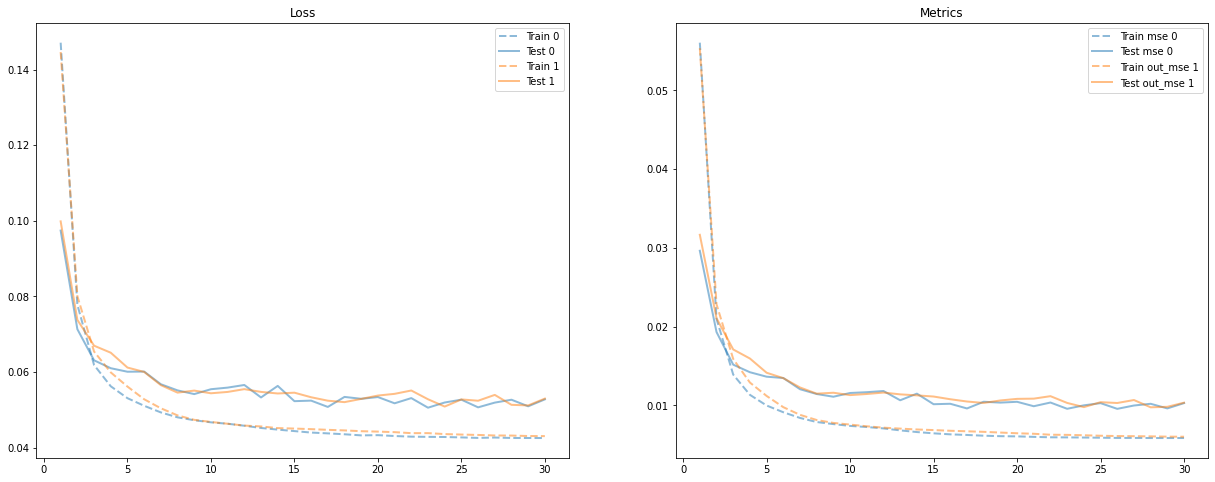

In [302]:
util.plot_training_history(history2, history3)

When inference is run on the `ae3` model the reconstructed profiles and the latent vectors are generated.

In [303]:
recon_data3, latent = nn2.predict(profile_data, batch_size=256)
print(recon_data3.shape, latent.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(9068, 84) (9068, 16)


Plotting the latent vectors as a 2D scatter using UMAP, as before, shows that the latent representation maintains the overall structure of the data, and shows a clear separation of the subcellular localisation class labels (not used here).

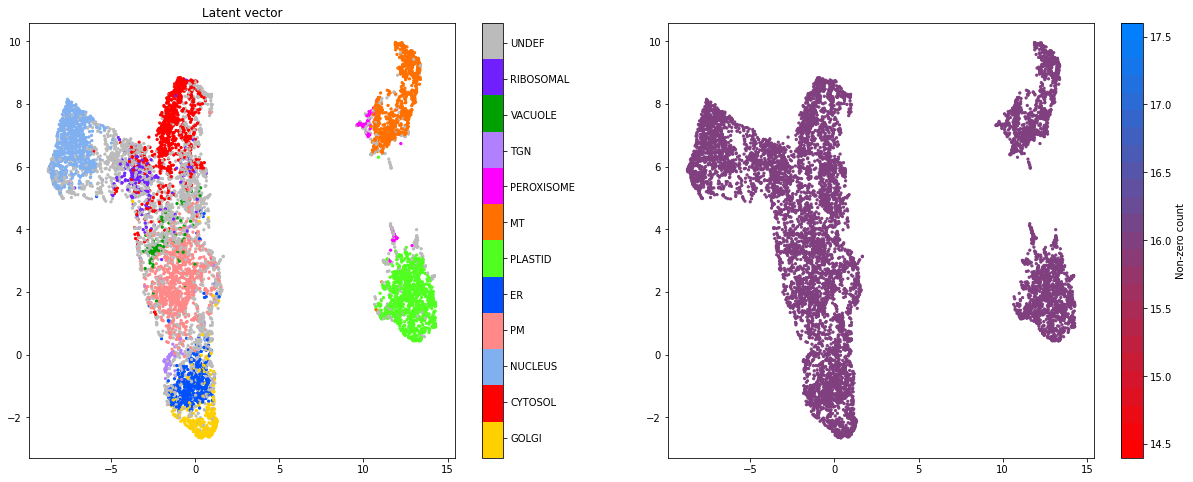

In [304]:
import importlib
importlib.reload(util)

util.plot_proteomics_data(latent, classifications, 'Latent vector')

The 2D UMAP plots of the original data can be compared to those of the reconstructed data. Arguably the reconstruction has improved the qualit yand separation of the data in a biologically meaningful manner.

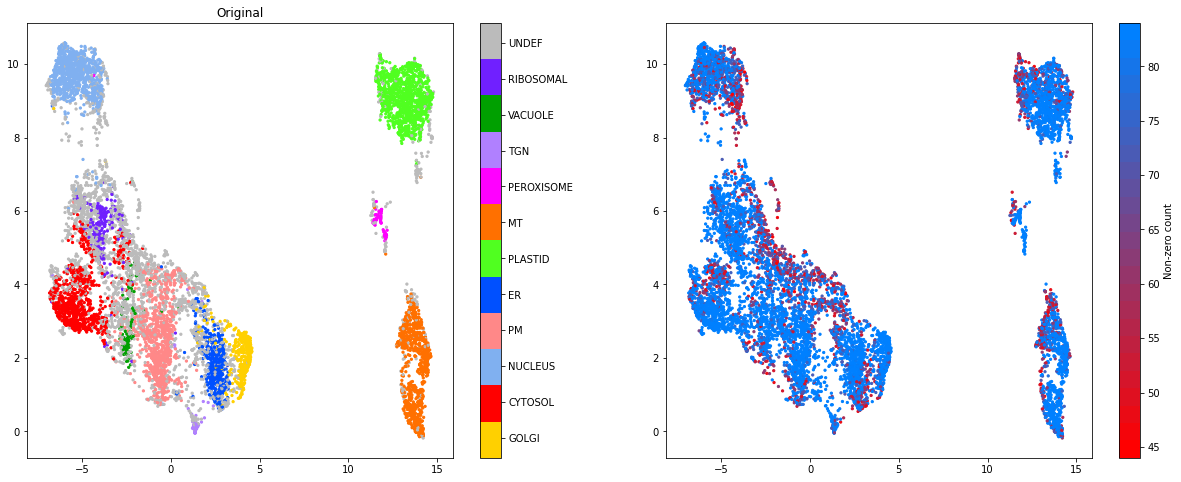

In [305]:
util.plot_proteomics_data(profile_data, classifications, 'Original')

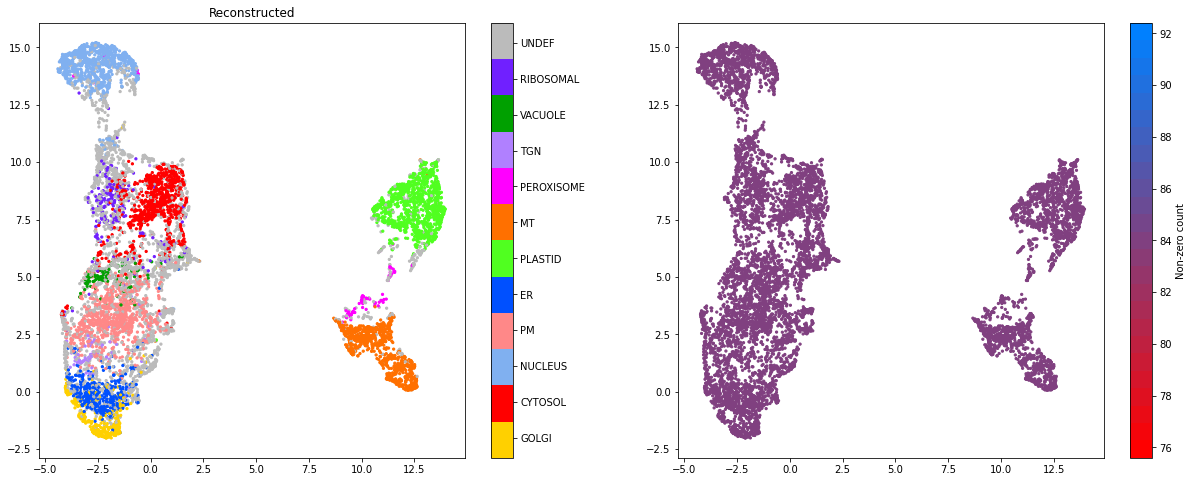

In [306]:
util.plot_proteomics_data(recon_data3, classifications, 'Reconstructed')